In [1]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [39]:
#Import libraries
import pandas as pd
import numpy as np
import os
import warnings
import time
import nfl_data_py as nfl
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, brier_score_loss, auc, classification_report, roc_curve, accuracy_score, precision_recall_curve
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
os.chdir("/Users/gmduncan/Desktop/NFL")

### Read in datasets and prepare them

In [40]:
train_df = pd.read_csv("train_sample.csv")
val_df = pd.read_csv("val_sample.csv")

# Sort dataframe and reset index to be able to evaluate model later
train_df = train_df.sort_values(by=['gameId','playId','nflId','frameId']).reset_index(drop=True)
val_df = val_df.sort_values(by=['gameId','playId','nflId','frameId']).reset_index(drop=True)

# Create eval df without extending dv to evaluate later
eval_df = val_df[val_df['tackle_binary_single'] == 1].copy()

In [41]:
# TODO: temporary until we fix dataset
train_df['tackle_efficiency_ingame'].fillna(0, inplace=True)
train_df['tackle_rating_ingame'].fillna(0, inplace=True)

val_df['tackle_efficiency_ingame'].fillna(0, inplace=True)
val_df['tackle_rating_ingame'].fillna(0, inplace=True)

# TODO: additional metrics we can include 
# Relative speed to ball carrier
train_df['relative_speed'] = train_df['s'] - train_df['bcs']

# Relative direction to ball carrier
train_df['relative_direction'] = train_df['unitDir'] - train_df['bcdir']
train_df['relative_direction'] = train_df['relative_direction'].apply(lambda x: (x + 360) % 360 if x < 0 else x % 360)

# Relative angle to ball carrier
x_diff = train_df['x'] - train_df['bcx']
y_diff = train_df['y'] - train_df['bcy']
train_df['relative_angle'] = np.arctan2(y_diff, x_diff) * (180/np.pi) 

# Relative speed to ball carrier
val_df['relative_speed'] = val_df['s'] - val_df['bcs']

# Relative direction to ball carrier
val_df['relative_direction'] = val_df['unitDir'] - val_df['bcdir']
val_df['relative_direction'] = val_df['relative_direction'].apply(lambda x: (x + 360) % 360 if x < 0 else x % 360)

# Relative angle to ball carrier
x_diff = val_df['x'] - val_df['bcx']
y_diff = val_df['y'] - val_df['bcy']
val_df['relative_angle'] = np.arctan2(y_diff, x_diff) * (180/np.pi) 

### Extend the dependent variable to other frames

In [42]:
frames_to_extend = 5
extend_dv = 'tackle_binary_single'

# Identify rows where tackle_binary_single is equal to 1
tackle_rows_train = train_df[train_df[extend_dv] == 1]

# Create a list to store the indices of rows to be updated
rows_to_update_train = []

# Get identifiers for each row with tackle_binary_single = 1 
for _, row in tackle_rows_train.iterrows():
    gamePlayId = row['gamePlayId']
    nflId = row['nflId']
    frameId = row['frameId']

    # Identify the rows to be updated based on gamePlayId, nflId, and frame
    rows_to_update_train.extend(
        train_df[
            (train_df['gamePlayId'] == gamePlayId) &
            (train_df['nflId'] == nflId) &
            (train_df['frameId'] > frameId - frames_to_extend) 
        ].index
    )
    
# Update the values in the identified rows
train_df.loc[rows_to_update_train, extend_dv] = 1

# Identify rows where tackle_binary_single is equal to 1
tackle_rows_val = val_df[val_df[extend_dv] == 1]

# Create a list to store the indices of rows to be updated
rows_to_update_val = []

# Get identifiers for each row with tackle_binary_single = 1 
for _, row in tackle_rows_val.iterrows():
    gamePlayId = row['gamePlayId']
    nflId = row['nflId']
    frameId = row['frameId']

    # Identify the rows to be updated based on gamePlayId, nflId, and frame
    rows_to_update_val.extend(
        val_df[
            (val_df['gamePlayId'] == gamePlayId) &
            (val_df['nflId'] == nflId) &
            (val_df['frameId'] > frameId - frames_to_extend) 
        ].index
    )
    
# Update the values in the identified rows
val_df.loc[rows_to_update_val, 'tackle_binary_single'] = 1

### Identify which columns to keep and drop, update dataframes

In [6]:
used_dv = ['tackle_binary_single']
all_dv = ['tackle_binary_all','tackle_nonbinary_all','tackle_nonbinary_single', 'tackle_binary_single']
cols_to_drop = ['gameId', 'playId', 'frameId', 'nflId'] + all_dv 

x_train = train_df.drop(columns = cols_to_drop)
x_val = val_df.drop(columns = cols_to_drop)

y_train = train_df[used_dv]
y_val = val_df[used_dv]

### Convert object variables to category variables

In [7]:
object_cols = x_train.select_dtypes(include='object').dtypes.index

x_train[object_cols] = x_train[object_cols].astype('category')
x_val[object_cols] = x_val[object_cols].astype('category')

### Prepare datasets to pass into model

In [8]:
# Ensure observations of a play within a game are grouped together
group_sizes_train = x_train.groupby('gamePlayId').size().tolist()
group_sizes_val = x_val.groupby('gamePlayId').size().tolist()

x_train = x_train.drop(columns = 'gamePlayId')
x_val = x_val.drop(columns = 'gamePlayId')

# Convert data into DMatrix format (XGBoost's internal data structure)
dtrain = xgb.DMatrix(x_train, label=y_train, enable_categorical=True, group=group_sizes_train)
dval = xgb.DMatrix(x_val, label=y_val, enable_categorical=True, group=group_sizes_val)

### Create XGBoost model

In [9]:
# Set hyperparameters for XGBoost model
params = {
    'objective': 'binary:logistic',  # for binary classification
    'eval_metric': 'logloss',  # use logloss for binary classification problems todo: test between logloss, error, auc
    'max_depth': 4,  # maximum depth of the tree
    'eta': 0.05,  # learning rate
    'subsample': 0.9,  # fraction of samples used for fitting the trees
    'colsample_bytree': 0.9,  # fraction of features used for fitting the trees
    'n_estimators': 140,
    'gamma': 0.2,
    'min_child_weight': 5,
    'scale_pos_weight': 5
}

# Set hyperparameters for XGBoost model
# params = {
#     'objective': 'binary:logistic',  # for binary classification
#     'eval_metric': 'logloss',  # use logloss for binary classification problems todo: test between logloss, error, auc
#     'colsample_bytree': 0.8, 
#     'gamma': 0.4, 
#     'learning_rate': 0.1,
#     'max_depth': 6, 
#     'min_child_weight': 10, 
#     'n_estimators': 180, 
#     'reg_alpha': 1, 
#     'reg_lambda': 0, 
#     'scale_pos_weight': 4, 
#     'subsample': 0.8
# }

# Train the XGBoost model with early stopping
num_rounds = 1000  
early_stopping_rounds = 10  

# Specify the validation set for early stopping
evals = [(dtrain, 'train'), (dval, 'validation')]

# Define the model
model = xgb.train(params, dtrain, num_rounds, evals=evals, early_stopping_rounds=early_stopping_rounds)

[0]	train-logloss:0.20575	validation-logloss:0.20644
[1]	train-logloss:0.19781	validation-logloss:0.19852
[2]	train-logloss:0.19050	validation-logloss:0.19123
[3]	train-logloss:0.18374	validation-logloss:0.18453
[4]	train-logloss:0.17752	validation-logloss:0.17833
[5]	train-logloss:0.17171	validation-logloss:0.17258
[6]	train-logloss:0.16633	validation-logloss:0.16721
[7]	train-logloss:0.16125	validation-logloss:0.16213
[8]	train-logloss:0.15647	validation-logloss:0.15744
[9]	train-logloss:0.15205	validation-logloss:0.15306
[10]	train-logloss:0.14790	validation-logloss:0.14890
[11]	train-logloss:0.14401	validation-logloss:0.14506
[12]	train-logloss:0.14037	validation-logloss:0.14148
[13]	train-logloss:0.13690	validation-logloss:0.13804
[14]	train-logloss:0.13366	validation-logloss:0.13483
[15]	train-logloss:0.13060	validation-logloss:0.13183
[16]	train-logloss:0.12774	validation-logloss:0.12902
[17]	train-logloss:0.12500	validation-logloss:0.12630
[18]	train-logloss:0.12244	validation-

### Model evaluation

In [10]:
# Evaluate the model
predictions = model.predict(dval)
binary_predictions = [1 if p > 0.5 else 0 for p in predictions]

# Evaluate metrics
accuracy = accuracy_score(y_val, binary_predictions)
precision = precision_score(y_val, binary_predictions)
recall = recall_score(y_val, binary_predictions)
f1 = f1_score(y_val, binary_predictions)
roc_auc = roc_auc_score(y_val, binary_predictions)

print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}\n')

print(classification_report(y_val, binary_predictions))

Accuracy: 0.9683, Precision: 0.3556, Recall: 0.6157, F1-Score: 0.4508, ROC AUC: 0.7958

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     80586
           1       0.36      0.62      0.45      1738

    accuracy                           0.97     82324
   macro avg       0.67      0.80      0.72     82324
weighted avg       0.98      0.97      0.97     82324


### Visualize performance

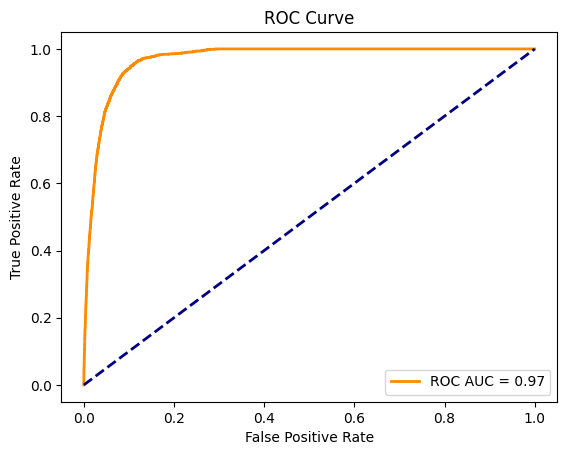

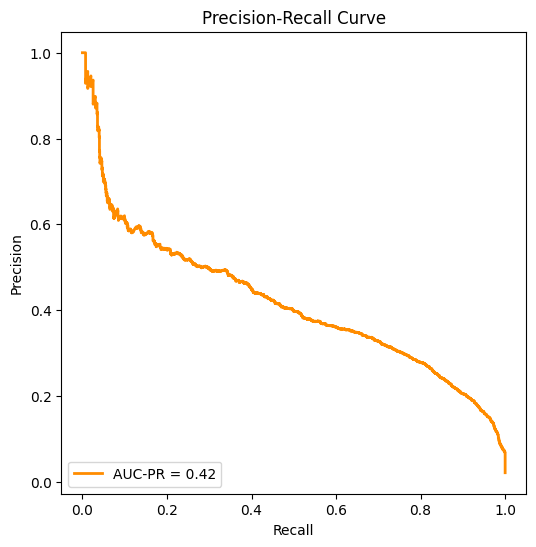

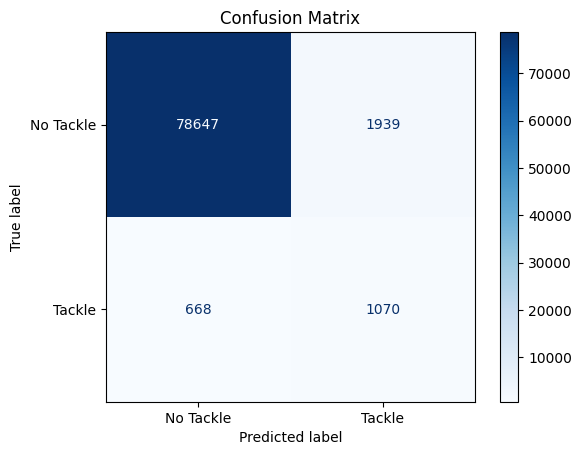

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

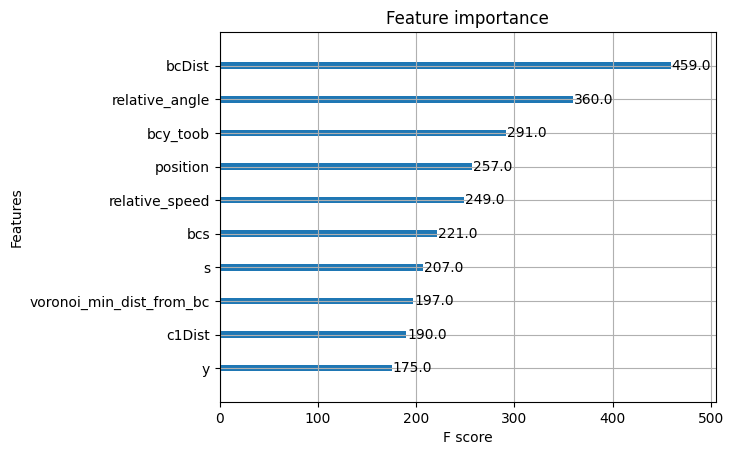

In [11]:
# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_val, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_val, predictions)
area_under_pr_curve = auc(recall, precision)

# Plotting the Precision-Recall Curve
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'AUC-PR = {area_under_pr_curve:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Calculate confusion matrix
cm = confusion_matrix(y_val, binary_predictions) 

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Tackle', 'Tackle'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Plot feature importance
xgb.plot_importance(model, max_num_features=10, importance_type='weight')

### Plot distribution of probabilities

(array([412., 434., 399., 388., 387., 315., 263., 215., 119.,  77.]),
 array([0.50013357, 0.54776025, 0.59538686, 0.64301348, 0.69064015,
        0.73826683, 0.78589344, 0.83352005, 0.88114673, 0.9287734 ,
        0.97640002]),
 <BarContainer object of 10 artists>)

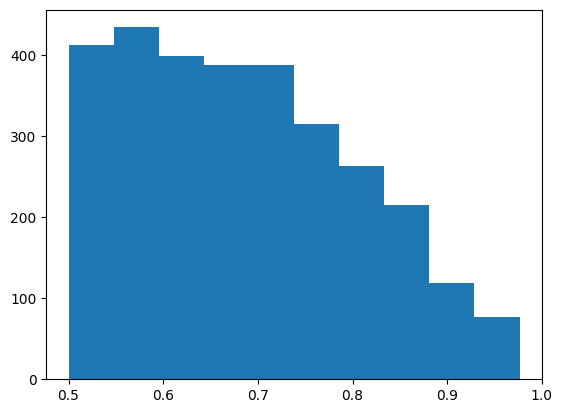

In [12]:
plt.hist(predictions[predictions > .5])

### Evaluate ability to identify a tackle in extended tackle frames

In [13]:
# Make binary predictions into a dataframe
binary_predictions_eval = pd.DataFrame(binary_predictions).rename(columns={0 : 'prediction'})

# Merge true labels output to predictions dataframe
binary_predictions_eval = binary_predictions_eval.merge(y_val, left_index = True, right_index = True, how = 'inner')

# Evaluate times it predicted tackle in any of the frames where tackle was extended
num_correct_tackle = 0

# Loop over eval_df 
for idx, row in eval_df.iterrows():
    # If tackle = 1, see if predicted a tackle on any of frames we extended tackle to for training
    if row['tackle_binary_single'] == 1:
        # Check if any of the previous 'frames_to_extend' frames have a prediction of 1
        if any(binary_predictions_eval.loc[idx - i, 'prediction'] == 1 for i in range(0, frames_to_extend)):
            num_correct_tackle += 1

### Display results of being able to identify a tackle

In [14]:
num_true_tackle = eval_df.tackle_binary_single.sum()

perc_true_tackle = num_correct_tackle / num_true_tackle
perc_missed_tackle = 1 - perc_true_tackle

print("Percentage of true tackles : ", perc_true_tackle, '\nPercentage of missed tackles: ', perc_missed_tackle)

Percentage of true tackles :  0.7514285714285714 
Percentage of missed tackles:  0.24857142857142855


### Merge all information together

In [15]:
# Merge probabilities back to original 
val_df_final = val_df.merge(pd.DataFrame(predictions), left_index=True, right_index=True, how='inner').rename(columns={0 : 'prediction'})
val_df_final = val_df_final[['gamePlayId','gameId','playId','nflId','frameId','tackle_binary_single','prediction']]

val_df_final

,gamePlayId,gameId,playId,nflId,frameId,tackle_binary_single,prediction
0,2022090800.01385.0,2.022091e+09,1385.0,37075.0,18.0,0,0.000162
1,2022090800.01385.0,2.022091e+09,1385.0,37075.0,19.0,0,0.000125
2,2022090800.01385.0,2.022091e+09,1385.0,37075.0,20.0,0,0.000103
3,2022090800.01385.0,2.022091e+09,1385.0,37075.0,21.0,0,0.000109
4,2022090800.01385.0,2.022091e+09,1385.0,37075.0,22.0,0,0.000101
...,...,...,...,...,...,...,...
82319,2022110700.03278.0,2.022111e+09,3278.0,54479.0,36.0,0,0.000033
82320,2022110700.03278.0,2.022111e+09,3278.0,54479.0,37.0,0,0.000037
82321,2022110700.03278.0,2.022111e+09,3278.0,54479.0,38.0,0,0.000046
82322,2022110700.03278.0,2.022111e+09,3278.0,54479.0,39.0,0,0.000044


### Additional histograms to see how probabilities are distributed in different instances

(array([141., 100.,  90., 147., 162., 211., 224., 297., 238., 128.]),
 array([0.00225651, 0.09967086, 0.1970852 , 0.29449955, 0.39191392,
        0.48932827, 0.58674264, 0.68415695, 0.78157133, 0.87898564,
        0.97640002]),
 <BarContainer object of 10 artists>)

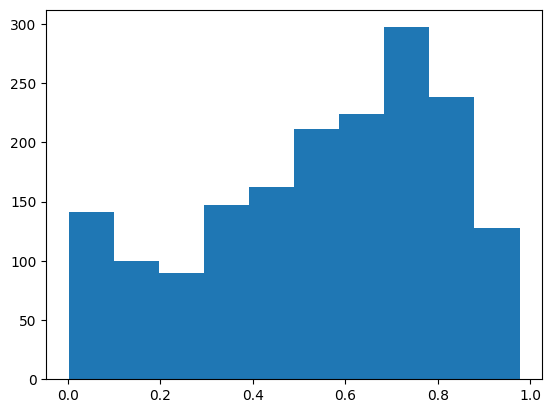

In [16]:
probs_for_tackles = val_df_final[val_df_final['tackle_binary_single'] == 1]
plt.hist(probs_for_tackles.prediction, bins = 10)

(array([25., 19., 19., 24., 24., 40., 44., 61., 55., 39.]),
 array([0.00267208, 0.09988351, 0.19709495, 0.29430637, 0.39151782,
        0.48872924, 0.58594066, 0.68315208, 0.78036356, 0.87757498,
        0.9747864 ]),
 <BarContainer object of 10 artists>)

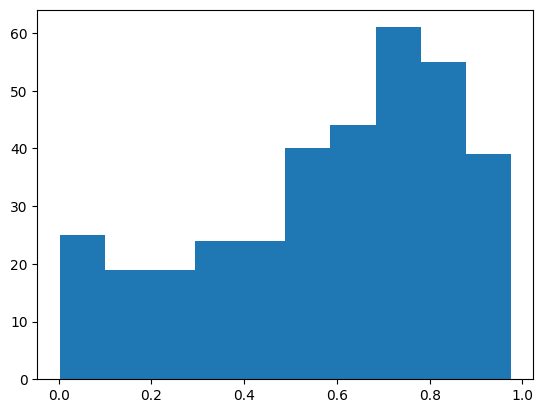

In [53]:
probs_no_tackles = val_df_final[val_df_final['tackle_binary_single'] == 0]
plt.hist(probs_no_tackles.prediction, bins = 10)

(array([73972.,  1893.,  1263.,  1091.,   879.,   827.,   772.,   678.,
          431.,   168.]),
 array([5.48641174e-06, 9.76421461e-02, 1.95278808e-01, 2.92915463e-01,
        3.90552104e-01, 4.88188773e-01, 5.85825443e-01, 6.83462083e-01,
        7.81098723e-01, 8.78735423e-01, 9.76372063e-01]),
 <BarContainer object of 10 artists>)

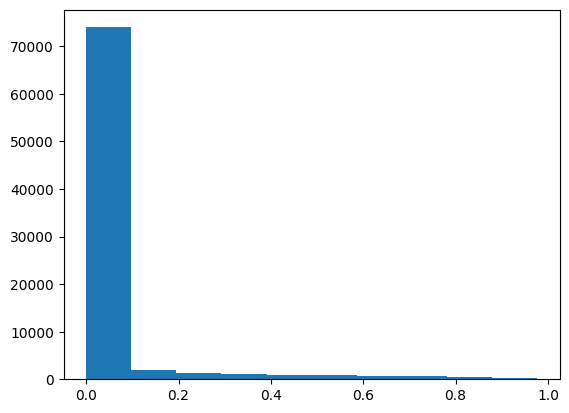

In [54]:
probs_over_50 = val_df_final[val_df_final['prediction'] >= 0.5]
plt.hist(probs_over_50.prediction, bins = 10)

(array([413., 425., 403., 381., 394., 317., 259., 214., 121.,  77.]),
 array([0.500054  , 0.5476858 , 0.5953176 , 0.6429494 , 0.6905812 ,
        0.73821306, 0.78584486, 0.83347666, 0.88110846, 0.92874026,
        0.97637206]),
 <BarContainer object of 10 artists>)

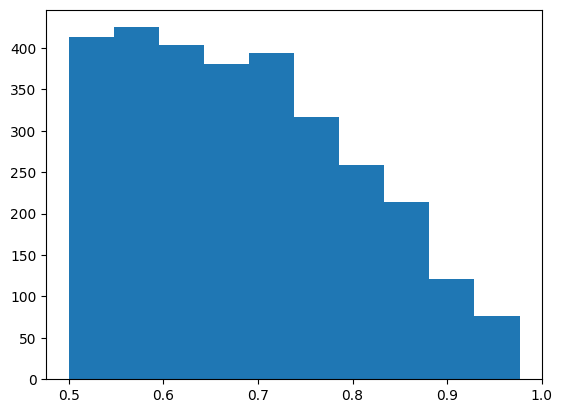

In [55]:
probs_under_50 = val_df_final[val_df_final['prediction'] < 0.5]
plt.hist(probs_under_50.prediction, bins = 10)

### Export results for write up

In [36]:
val_df_final.to_csv('model_results.csv', index=False)